<a href="https://colab.research.google.com/github/ChemistZee/python_quantum_chemistry_introductory/blob/main/DFT_for_computing_molecular_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages

In [2]:
! pip install rdkit
! pip install pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 13.7 MB/s eta 0:00:00


## Molecular properties

In the previous sessions, we looked at generating molecular input for DFT calculations and running single-point energy, optimization and frequency calculations. In this session we will run more calculations and analyse them to obtain molecular properties.

Session 1: Molecular input generation (https://www.youtube.com/watch?v=hHRMk5zx2Qw)

Session 2: DFT basics (https://www.youtube.com/watch?v=xfvmAH7q3Uk&t=312s)

## Molecular orbital (MO)

We will get the energy of HOMO and LUMO. We will also visualize the MOs

Let us start by running a SCF calculation

In [3]:
# import these definitions
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

# generate ethene molecule
smiles = "C=C"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(mol)
Chem.MolToXYZFile(mol, "ethene.xyz")

# import the package
from pyscf import gto, scf

mol = gto.M(atom="ethene.xyz")

# set basis set
mol.basis = "6-31G"

# set the functional
mf = mol.KS()
mf.xc = 'b3lyp'

# run energy calculations
neutral_energy = mf.kernel()

converged SCF energy = -77.6167501638518


Most electronic structure packages will give you HOMO and LUMO values. But here is how to get it manually



1.   Get the total number of electrons (n)
2.   HOMO is the n/2 orbital



In [ ]:
# total number of electrons
n = mol.tot_electrons()
n

16

In [ ]:
# display all orbitals
mf.mo_energy

array([-9.98868219, -9.98828492, -0.71607937, -0.53788474, -0.44467966,
       -0.35845419, -0.327403  , -0.21074797,  0.11348932,  0.40828965,
        0.42285591,  0.43970457,  0.63806545,  0.69045135])

In [ ]:
# HOMO is n/2 orbital. But python index starts from 0
homo = mf.mo_energy[int(n/2) - 1]
homo

np.float64(-0.21074797304611867)

In [ ]:
# the unit of energy is Hartree. To convert to eV
homo * 27.2114

np.float64(-5.734747393747154)

MOs are regions of electron density. They can be visualized.

In [ ]:
# import the definitions
from pyscf.tools import molden

# we will write the surface to molden files
with open('ethene.molden', 'w') as f1:
    molden.header(mol, f1)
    molden.orbital_coeff(mol, f1, mf.mo_coeff, ene=mf.mo_energy, occ=mf.mo_occ)

### Exercise

Get the HOMO-LUMO gap in Benzene. Use B3LYP/3-21G level of theory

In [4]:
# YOUR CODE HERE
smiles = 'C1=CC=CC=C1'
mol = Chem.MolFromSmiles(smiles)
mol_h = Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(mol_h)
Chem.MolToXYZFile(mol_h, 'benzene.xyz')

In [5]:
mol = gto.M(atom = 'benzene.xyz')
mol.basis = '3-21g'
mf = mol.KS()
mf.xc = 'b3lyp'
neutral_benzene = mf.kernel()

converged SCF energy = -229.398466944267


In [ ]:
n = mol.tot_electrons()
n

42

In [ ]:
homo = mf.mo_energy[int(n/2)-1]
homo

np.float64(-0.19496415530099723)

In [ ]:
lumo = mf.mo_energy[int(n/2)]
lumo

np.float64(0.0933443693986676)

In [ ]:
gap = (lumo-homo)* 27.2114
gap

np.float64(7.84527858901246)

In [ ]:
mf.mo_energy[20] #calling the index straight away

np.float64(-0.1969421001255837)

## Charged system

The systems we looked at were neutral. Let us run calculations for charged system

In [ ]:
# Run single-point energy for cation of ethene

# import the package
from pyscf import gto, scf

mol = gto.M(atom="ethene.xyz")

# set basis set
mol.basis = "6-31G"

########## SET CHARGE ################
mol.charge = 1
mol.spin = 1  #  (2*s) where s is the spin. some code use 2*s +1
#####################################

# set the functional
mf = mol.KS()
mf.xc = 'b3lyp'

# run energy calculations
cation_energy = mf.kernel()

converged SCF energy = -77.2661577378399  <S^2> = 0.75147788  2S+1 = 2.0014773


Now that we have total energy of neutral molecule and cationic molecule, we can compute ionization energy

In [ ]:
# ionization is the difference in energies
# we convert to eV
( neutral_energy - cation_energy ) * 27.2114

np.float64(-9.540110741179062)

### Exercise

Compute the electron affinity of benzene at B3LYP/3-21G level of theory.

Hint: electron affinity is energy required to add electron to system

In [6]:
# YOUR CODE HERE
mol = gto.M(atom = 'benzene.xyz')
mol.basis = '3-21g'
mol.charge = -1
mol.spin = 1
mf = mol.KS()
mf.xc = 'b3lyp'
anion_energy = mf.kernel()

converged SCF energy = -229.206305533236  <S^2> = 0.76463233  2S+1 = 2.0145792


In [7]:
anion_energy

np.float64(-229.20630553323608)

In [8]:
neutral_benzene

np.float64(-229.39846694426674)

In [9]:
(anion_energy-neutral_benzene)* 27.2114

np.float64(5.228981020119913)

## Solvent effects

Adding actual solvent molecules (explicit solvation) is computationally expensive. Implicit solvation uses dielectric constant to model polarization charges in molecule. [PCM](https://en.wikipedia.org/wiki/Polarizable_continuum_model) and [COSMO](https://en.wikipedia.org/wiki/COSMO_solvation_model) are popular solvation models.

Here we will use COSMO as it is the model implemented in [pySCF](https://pyscf.org/user/solvent.html).


In [10]:
mol = gto.M(atom="ethene.xyz")

# set basis set
mol.basis = "6-31G"

# set the functional
mf = mol.KS()
mf.xc = 'b3lyp'

# set solvent
mf = mf.DDCOSMO() #indicating the dielectric constant to try to simulate the presence of the solvent
mf.with_solvent.eps = 35.688  # Acetonitrile. this value can be found in the pySCF documentation

# run single point energy
mf = mf.run()

#get total energy
neutral_energy_solvent = mf.e_tot

converged SCF energy = -77.6172781658729


In [ ]:
# estimate of solvation enthalpy in eV
(neutral_energy_solvent - neutral_energy ) * 27.2114

np.float64(-0.014367674199251548)

## Time-dependent DFT (TD-DFT)

Behind the scene of TD-DFT is similar to DFT. We have basis set, functional, charge, spin etc. The difference in the equation we solve.

In DFT we solve time independent Kohn-Sham equation (similar to time independent Schrodinger equation). For TD-DFT we solve equation similar to time dependent Schrodinger equation

\begin{equation}
\hat{H}\Psi (x,t)=i\hbar\dfrac{\partial}{\partial t}\Psi (x,t)
\end{equation}

In [ ]:
from pyscf import gto, scf, dft, tddft

mol = gto.M(atom="ethene.xyz")

# set basis set
mol.basis = "6-31G"

# set DFT functional
mf = dft.RKS(mol)
mf.xc = 'b3lyp'


################## SELECT ONE ################

# initialize the mf object in gas phase
# mf.kernel()

# OR

# initialize the mf object in solvent
mf = mf.DDCOSMO()
mf.with_solvent.eps = 35.688  # Acetonitrile
mf = mf.run()

##################################################

# setup the TDDFT
td = tddft.TDDFT(mf)

# set type and number of states required
td.singlet = True
td.nstates = 10

# run TDDFT
td.kernel()

# analyze to show a table of excitations
td.analyze()

converged SCF energy = -77.617278165873
Excited State energies (eV)
[10.12537933 10.16441605 10.56999102 13.20994187 15.05985096 15.38034002
 16.34866912 17.63930028 19.24986855 19.40375382]

** Singlet excitation energies and oscillator strengths **
Excited State   1:     10.12538 eV    122.45 nm  f=0.0001
Excited State   2:     10.16442 eV    121.98 nm  f=0.4161
Excited State   3:     10.56999 eV    117.30 nm  f=0.0000
Excited State   4:     13.20994 eV     93.86 nm  f=0.0000
Excited State   5:     15.05985 eV     82.33 nm  f=0.0000
Excited State   6:     15.38034 eV     80.61 nm  f=0.0009
Excited State   7:     16.34867 eV     75.84 nm  f=0.0000
Excited State   8:     17.63930 eV     70.29 nm  f=0.3990
Excited State   9:     19.24987 eV     64.41 nm  f=0.0682
Excited State  10:     19.40375 eV     63.90 nm  f=0.0034


In [ ]:
# helper function to plot absorption spectrum
def plot_absorption(td_obj, step=0.01, sigma=0.05):
    import scipy.constants as cst
    import numpy as np
    from scipy.stats import norm
    import matplotlib.pyplot as plt

    # get transitions can convert to eV
    transitions =  td_obj.e * 27.2114

    # get oscilator strengths
    f = td_obj.oscillator_strength()

    # get minimum and miximum x-values for plot
    minval = min([val for val in transitions]) - 5.0 * sigma
    maxval = max([val for val in transitions]) + 5.0 * sigma

    # number of data points in line
    npts = int((maxval - minval) / step) + 1

    # generating the plot
    eneval = np.linspace(minval, maxval, npts)  # in eV
    lambdaval = [cst.h * cst.c / (val * cst.e) * 1.e9
                 for val in eneval]  # in nm

    # sum of gaussian functions
    spectra = np.zeros(npts)
    for i in range(len(transitions)):
        spectra += f[i] * norm.pdf(eneval, transitions[i], sigma)
    spectra /= spectra.max()

    # plot the spectrum
    plt.plot(lambdaval,spectra)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorption (au)")

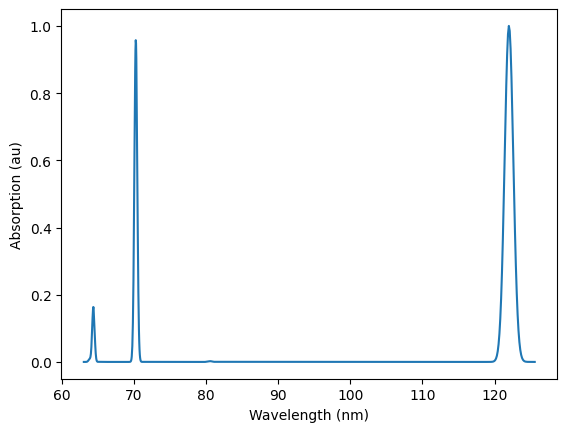

In [ ]:
# plot the absorption from td
plot_absorption(td)

Congratulations!! You have completed the Quantum Chemistry with python series.

Please take this survey to help improve future workshops https://docs.google.com/forms/d/e/1FAIpQLSdpn3lpq1n1fA4aqLDvfA9VARsTNBnD5p6gcCtJ_VaYGiYxlA/viewform?usp=sf_link

# Get your LinkedIn sharable certificate

Steps to get your certificate


1.   Complete the task below. You should insert code in the cells with "YOUR CODE HERE"
2.   Print the notebook File --> Print. Do not change the file name while you save as PDF.
3.  Go to [this](https://www.vinayakbhat.xyz/chemistrywithcode/certificates/) page. Fill in the form and add the PDF file of the notebook from step 2.
4.  Save your certificate as an image. You can click on "Add to LinkedIn" to share it on LinkedIn.




# Task

You will reproduce results from the article [J. Mater. Chem. C, 2016,4, 2931-2935](https://doi.org/10.1039/C5TC03188E). The article contains results from experiments and computations. The molecule investigated is 4-amino-2,2′-bipyridine (see below for graphical abstract).

**Perform all your calculations with B3LYP functional and basis set 6-31G****

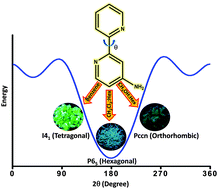

First, we will generate the 3D structure of the molecule 4-amino-2,2′-bipyridine.

In [ ]:
# YOUR CODE HERE

Now optimize the structure in gas phase and run frequency calculations to confirm convergence

In [ ]:
# YOUR CODE HERE

Generate the MOs and compare your results with Figure S10 in the [SI](https://www.rsc.org/suppdata/c5/tc/c5tc03188e/c5tc03188e1.pdf)

In [ ]:
# YOUR CODE HERE

To compare absorption spectrum in Figure S11 of the [SI](https://www.rsc.org/suppdata/c5/tc/c5tc03188e/c5tc03188e1.pdf), run TDDFT calcluations in chloroform with the optimized structure.

In [ ]:
# YOUR CODE HERE

Finally, perform the dihedral angle scan to get the potential energy surface as shown in Figure S1 of the [SI](https://www.rsc.org/suppdata/c5/tc/c5tc03188e/c5tc03188e1.pdf)

Hint: Run SCF calculations for different dihedral angle. You can omit optimization of the structure with dihedral [constraints](https://pyscf.org/user/geomopt.html).

For plotting in python you may find [this video](https://youtu.be/hNNRVRmZO1s?t=8317) helpful.

In [ ]:
# YOUR CODE HERE

Congratulations! You have reached the end of the task. You can now follow the instructions to get your certificate.

## Want to participate in more workshops?



Folow Chemistry With Code on [Facebook](https://www.facebook.com/ChemistryWithCode) and [YouTube](https://www.youtube.com/c/Chemistrywithcode/) to get updates on future workshops